# Sliceguard for AutoML
Sliceguard can be applied for doing a quick modeling of your problem in few lines of code.

It offers the following advantages over other libraries:
1. Handles feature encoding and normalization automatically
2. Supports mixing structured and unstructured data out of the box
3. Hyperparameter Tuning is also built-in using FLAML
4. Built-in interactive report including problematic slices and prediction explanations.

Note that sliceguard does not aim at replacing any AutoML tooling out there. Its use lies mostly in the quick modeling of a problem in a very opinionated way to get a first glance on the problems you might be dealing with and to evaluate the feasability of use cases and datasets in general.

# Example

In the following example we want to estimate the subjective rating of a wine using a mix of structured and unstructured data. Sliceguard thus has to make use of structured features as well a unstructured features like text data.

In [16]:
# Import Sliceguard
from sliceguard import SliceGuard
from sliceguard.data import from_huggingface
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

In [6]:
# Load the data
df = from_huggingface("alfredodeza/wine-ratings")
df = df.sample(2000) # subsample for quicker execution

In [12]:
# Display the data
df

,name,region,variety,rating,notes,split
30215,Kim Crawford Sauvignon Blanc 2012,"Marlborough, New Zealand",White Wine,91.0,"Upfront herbaceous aromas, backed by ripe frui...",train
3468,Banfi Le Rime Pinot Grigio 2011,"Tuscany, Italy",White Wine,87.0,Pale straw yellow. Hints of pear and white flo...,train
6285,Booker Vineyard My Favorite Neighbor 2010,"Paso Robles, Central Coast, California",Red Wine,92.0,This version of MFN has many more layers and m...,train
14830,Clos Saint-Jean Chateauneuf-du-Pape Blanc 2011,"Chateauneuf-du-Pape, Rhone, France",White Wine,92.0,"A blend of equal parts Grenache, Clairette and...",train
10568,Chateau de Beaucastel Chateauneuf-du-Pape Blan...,"Chateauneuf-du-Pape, Rhone, France",White Wine,92.0,The white wines of Château de Beaucastel are a...,train
...,...,...,...,...,...,...
18799,Domaine Huet Vouvray Haut Lieu Demi-Sec (375ML...,"Vouvray, Touraine, Loire, France",White Wine,96.0,Taking its roots deep into the chalk soils of ...,train
21994,Famille Perrin Reserve Cotes du Rhone Blanc 2007,"Cotes du Rhone, Rhone, France",White Wine,88.0,Jean Pierre and Francois Perrin have taken par...,train
22572,Fess Parker Santa Barbara Chardonnay 2000,"Central Coast, California",White Wine,89.0,"You will find notes of tropical fruits, citrus...",train
15814,Cottanera Etna Bianco 2017,"Sicily, Italy",White Wine,91.0,100% Carricante from vineyards that sit at 720...,train


In [10]:
# Split the data
train_df, test_df = train_test_split(df)

In [23]:
# Fit the model
sg = SliceGuard()
sg.fit(train_df, "rating", features=["name", "region", "variety", "notes"], task="regression", time_budget=60)

Feature name was inferred as referring to raw data. If this is not the case, please specify in feature_types!
Feature region was inferred as being categorical. Will be treated as nominal by default. If ordinal specify in feature_types and feature_orders or use Pandas categoricals!
Feature variety was inferred as being categorical. Will be treated as nominal by default. If ordinal specify in feature_types and feature_orders or use Pandas categoricals!
Feature notes was inferred as referring to raw data. If this is not the case, please specify in feature_types!
Using default model for computing embeddings for feature name.
Embedding computation on cuda with batch size 1 and multiprocessing None.
Pre-reducing feature name in mode automl.
Using op mix ratio 0.8.
Using num dimensions 8.
Using default model for computing embeddings for feature notes.
Embedding computation on cuda with batch size 1 and multiprocessing None.
Pre-reducing feature notes in mode automl.
Using op mix ratio 0.8.
Us

[{'id': 0,
  'level': 3,
  'indices': array([13859, 13860]),
  'rows': array([  16, 1179]),
  'metric': 4.719104766845703,
  'explanation': [{'column': 'notes', 'importance': 0.9999999999999999},
   {'column': 'variety', 'importance': 0.0, 'mode': 'Red Wine'},
   {'column': 'region',
    'importance': 0.0,
    'mode': 'Pomerol, Bordeaux, France'},
   {'column': 'name', 'importance': 0.0}]},
 {'id': 1,
  'level': 3,
  'indices': array([16980, 25806, 25907, 25912]),
  'rows': array([  67,  801, 1020, 1213]),
  'metric': 3.410919189453125,
  'explanation': [{'column': 'name', 'importance': 0.9999999999999999},
   {'column': 'notes', 'importance': 0.0},
   {'column': 'variety', 'importance': 0.0, 'mode': 'Red Wine'},
   {'column': 'region',
    'importance': 0.0,
    'mode': 'Cote Rotie, Rhone, France'}]},
 {'id': 2,
  'level': 3,
  'indices': array([14153,  4307, 20580]),
  'rows': array([  76, 1058, 1085]),
  'metric': 2.80218505859375,
  'explanation': [{'column': 'notes', 'importance':

In [24]:
# Generate predictions
preds = sg.predict(test_df)

Embedding computation on cuda with batch size 1 and multiprocessing None.
Embedding computation on cuda with batch size 1 and multiprocessing None.


In [25]:
# Print model metrics
print(f"The r2-score of the model is {r2_score(test_df['rating'], preds)}")
print(f"The MAE of the model is {mean_absolute_error(test_df['rating'], preds)}")

The r2-score of the model is 0.13445270169148438
The MAE of the model is 1.7744297981262207


Embedding computation on cuda with batch size 1 and multiprocessing None.
Embedding computation on cuda with batch size 1 and multiprocessing None.


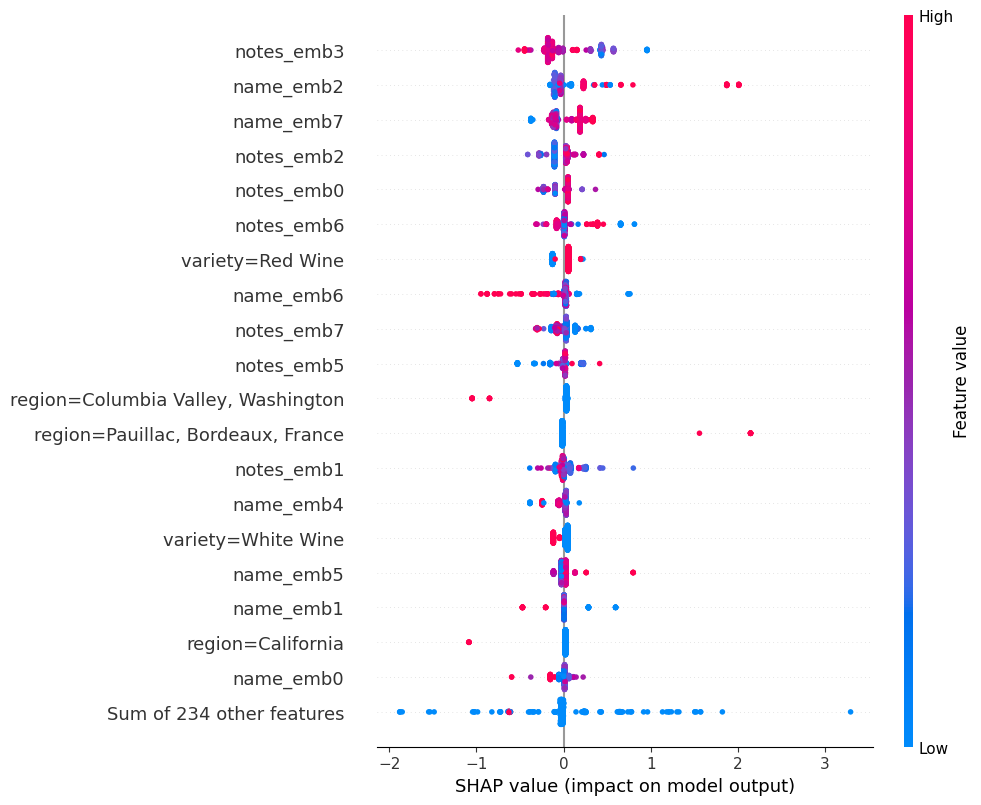

In [27]:
# Generate explanations
shap_explanations = sg.explain(test_df)

You already get some insights from the beeswarm plot that is done using the shape library. E.g. that red wines are generally higher rated in the dataset and that also some regions are corresponding to higher or lower ratings. There is also a lot of information in the unstructured text data that the model uses. However, you would have to look into the data to find out why this is the case. However, note that you can definitely do that as the method gives you a "SHAP Explanation Object" that you can use for further investigation.

In [30]:
# Get an interactive report on especially bad performing clusters
sg.report()

(                                                    name  \
 4250   Berger Lossterrassen Kremstal DAC Gruner Veltl...   
 24059                             Gagliole Valletta 2014   
 4972               Bleasdale Langhorne Creek Shiraz 2000   
 6813          Bravium Rosella's Vineyard Chardonnay 2014   
 15101                           Colosi Nero d'Avola 2008   
 ...                                                  ...   
 26914               Hermanos Pecina Senorio Crianza 2000   
 29655                  Kay Brothers Hillside Shiraz 2010   
 5557                           Bodegas Muga Reserva 2009   
 17897  Domaine de la Cote Sta. Rita Hills Pinot Noir ...   
 23394                       Four Graces Pinot Blanc 2017   
 
                                                   region     variety  rating  \
 4250                                   Kremstal, Austria  White Wine    93.0   
 24059                                     Tuscany, Italy    Red Wine    91.0   
 4972                  